In [1]:
%matplotlib inline
%run ../../path_import.py
import numpy as np
import matplotlib.pyplot as plt
from plots import *
from utils import *
from training_os import *
from model_mu_reparam import *
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
Data = torch.from_numpy(np.load('../rings_fixed_radius/obs.npy')).float()
## Data Parameters
N = 300
K = 3
D = 2
FIXED_RADIUS = 1.5
## Model Parameters
MCMC_SIZE = 20
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 8
NUM_HIDDEN_LOCAL = 64
STAT_SIZE = 8
NUM_LATENTS =  D
## Training Parameters
BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE =  1e-4
CUDA = torch.cuda.is_available()
PATH = 'ag-os-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)
DEVICE = torch.device('cuda:1')

In [3]:
enc_mu = Enc_mu(K, D, num_hidden=NUM_HIDDEN_GLOBAL, num_stats=STAT_SIZE, CUDA=CUDA, device=DEVICE)
enc_z = Gibbs_z(K, CUDA, DEVICE)
oneshot_mu = Oneshot_mu(K, D, num_hidden=NUM_HIDDEN_GLOBAL, num_stats=STAT_SIZE, CUDA=CUDA, device=DEVICE)
obs_rad = torch.ones(1) * FIXED_RADIUS
noise_sigma = torch.ones(1) * 0.05
if CUDA:
    enc_mu.cuda().to(DEVICE)
    oneshot_mu.cuda().to(DEVICE)
    obs_rad = obs_rad.cuda().to(DEVICE)
    noise_sigma =noise_sigma.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_mu.parameters())+list(enc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [4]:
RESAMPLE=True
DETACH=True
train_mu(Eubo_cfz_os_eta, oneshot_mu, enc_mu, enc_z, optimizer, Data, obs_rad, noise_sigma, K, NUM_EPOCHS, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, PATH, CUDA, DEVICE, RESAMPLE=RESAMPLE, DETACH=DETACH)

epoch=0, SymKL=284306.252, EUBO=-1545964.700, ELBO=-7516395.830, ESS=1.005 (23s)
epoch=1, SymKL=250554.015, EUBO=-1612357.380, ELBO=-6873991.570, ESS=1.005 (23s)
epoch=2, SymKL=222962.074, EUBO=-1642003.950, ELBO=-6324207.390, ESS=1.005 (22s)
epoch=3, SymKL=201452.214, EUBO=-1698652.539, ELBO=-5929148.990, ESS=1.005 (22s)
epoch=4, SymKL=181830.858, EUBO=-1727283.710, ELBO=-5545731.665, ESS=1.005 (23s)
epoch=5, SymKL=161300.121, EUBO=-1730214.805, ELBO=-5117517.327, ESS=1.006 (23s)
epoch=6, SymKL=142954.085, EUBO=-1685953.084, ELBO=-4687988.805, ESS=1.006 (23s)
epoch=7, SymKL=125651.405, EUBO=-1630387.859, ELBO=-4269067.325, ESS=1.007 (23s)
epoch=8, SymKL=109504.375, EUBO=-1599097.752, ELBO=-3898689.592, ESS=1.007 (20s)
epoch=9, SymKL=95463.140, EUBO=-1570261.597, ELBO=-3574987.495, ESS=1.006 (23s)
epoch=10, SymKL=82342.980, EUBO=-1546954.212, ELBO=-3276156.763, ESS=1.006 (23s)
epoch=11, SymKL=71877.592, EUBO=-1519166.774, ELBO=-3028596.158, ESS=1.005 (22s)
epoch=12, SymKL=62326.067, EU

In [5]:
torch.save(enc_mu.state_dict(), "../weights/enc-mu-%s" % PATH)
torch.save(oneshot_mu.state_dict(), "../weights/oneshot-mu-%s" % PATH)
# torch.save(enc_z.state_dict(), "../weights/enc-z-%s" % PATH)

CPU times: user 2.91 s, sys: 56.6 ms, total: 2.97 s
Wall time: 2.5 s


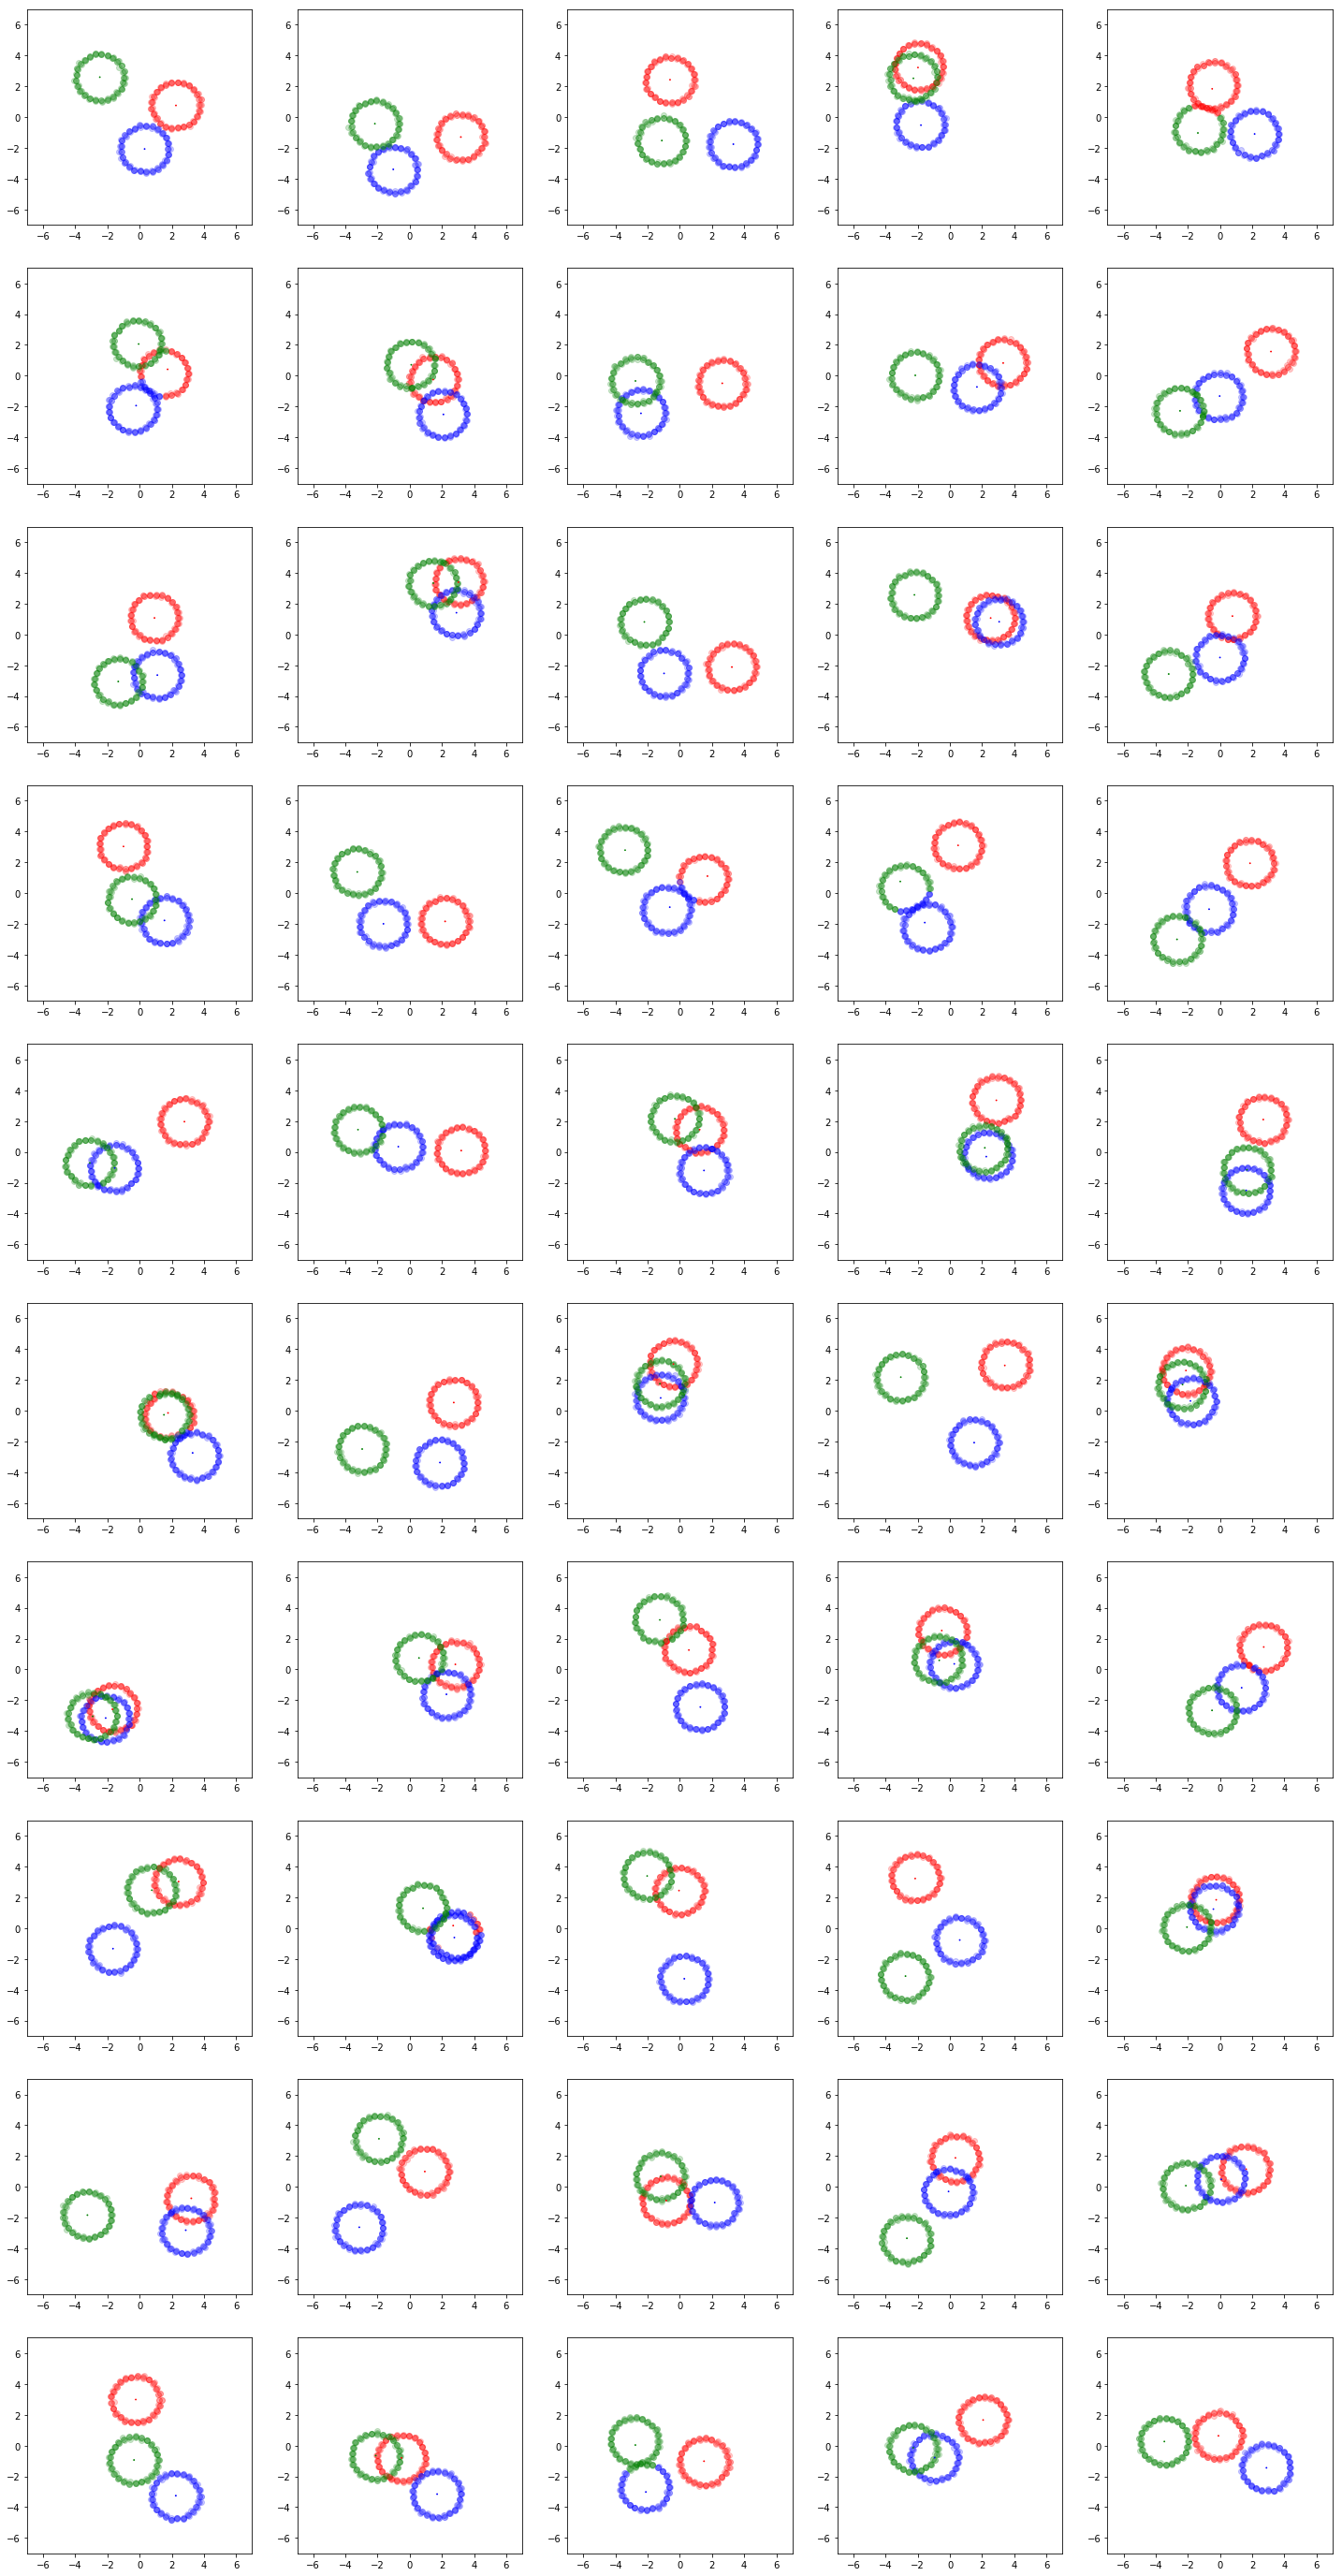

In [8]:
BATCH_SIZE_TEST = 50
obs, q_mu, q_z, symkls_test, eubos_test, elbos_test = test(Eubo_cfz_os_eta, oneshot_mu, enc_mu, enc_z, Data, obs_rad, noise_sigma, K, 10, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, RESAMPLE, DETACH=DETACH)
%time plot_samples(obs, q_mu, q_z, K, PATH)

In [ ]:
incremental_gap = symkls_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')